# Plot a comparison of the abundance contours between the data and APW's  model

In [24]:
# import agama
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher
from astropy.convolution import convolve, Gaussian2DKernel

In [25]:
%matplotlib inline
import numpy as np
import gala.integrate as gi
import gala.potential as gp
# from make_toy_data import get_potentials
from config import agama_pot
from scipy.ndimage import gaussian_filter
from config import R0, vc0, gala_pot, agama_pot


In [26]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
import vorbin
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')
import jax

In [27]:
# tbl = at.QTable.read('../../data/toy-df.fits')
data = at.QTable.read('../../data/df-qiso.fits')
len(data)

60605380

In [28]:
gala_pot = gp.load("../../data/MilkyWayPotential2022.yml")
R0 = 8.275 * u.kpc
vcirc = gala_pot.circular_velocity(R0 * [1.0, 0, 0])[0]

In [29]:
mask = np.ones(len(data), dtype=bool)
# mask = (
#     (tbl['J'][:, 0].value < 0.05)
#     & (np.abs(tbl['J'][:, 2] - np.median(tbl['J'][:, 2])).value < 0.05)
# #     & (tbl['R'] >= 8.27*u.kpc)& (tbl['R'] <= 8.9*u.kpc)
# )
mask.sum()

60605380

In [30]:
# Mg/Fe
rng = np.random.default_rng(seed=42)

# Trend and dispersion eyeballed from APOGEE:
data['MG_FE'] = rng.normal(
    np.sqrt(0.15) * data['J'][:, 2].value**0.5 + 0.025,
    0.04
)

In [31]:
null_mask = np.ones(len(data), dtype=bool)
mask = (
    (np.abs(data['R'] - R0) < 0.5*u.kpc)
    & (np.abs(data['R'] - data['Rg']) < 0.5*u.kpc) 
    & (np.abs(data['v_R']) < 15*u.km/u.s)
)
mask_data = data[mask]
len(mask_data)

3978462

In [32]:
import agama

In [33]:
vzlim = (-100,100)
zlim = (-3, 3)

# A grid spaced in Jz:

JR = 0. * u.kpc**2/u.Myr
Jphi = R0 * vc0

Norbits = 12
orbits = []
zvzs = []

Nt = 1024
zeros = np.zeros(Nt)

Jzs = np.linspace(1e-2, np.sqrt(0.2), Norbits) ** 2 * u.kpc**2 / u.Myr
Omzs = []
for Jz in Jzs:
    act = u.Quantity([JR, Jz, Jphi]).to_value(u.kpc**2 / u.Myr)
    torus_mapper = agama.ActionMapper(agama_pot, act, tol=1e-7)
    Omzs.append(torus_mapper.Omegaz)
    
    T = 1.025*2 * np.pi / torus_mapper.Omegaz
    t_grid = np.linspace(0, T, Nt)
    
    xv0 = torus_mapper([0.,0,0]).T
#     print(xv0)
    orbit = gala_pot.integrate_orbit(xv0, t=t_grid, Integrator=gi.DOPRI853Integrator)
    zvzs.append((orbit.z.to_value(u.kpc), orbit.v_z.to_value(u.km/u.s)))
    orbits.append(orbit)

In [34]:
def get_zvz_reflected_data(data, other_cols=None):
    if other_cols is None:
        other_cols = []
    
    other = {k: data[k] for k in other_cols}
    
    new_data = []
    for i in [-1, 1]:
        for j in [-1, 1]:
            new_data.append({"z": i * np.abs(data['z']), "v_z": j * np.abs(data['v_z']), **other})
            
    return at.vstack([at.QTable(x) for x in new_data])

In [35]:
refl_data = get_zvz_reflected_data(mask_data, ['MG_FE'])

In [36]:
from scipy.stats import binned_statistic_2d


In [37]:
Nbins = 151
smooth_kernel = Gaussian2DKernel(2.)
zvz_data = mask_data

bins = (np.linspace(*vzlim, Nbins), np.linspace(*zlim, Nbins))

H, xe, ye = np.histogram2d(
    zvz_data["v_z"].to_value(u.km / u.s), zvz_data["z"].to_value(u.kpc), bins=bins, density=True
)
# H /= H.max()

_H, *_ = np.histogram2d(
    refl_data["v_z"].to_value(u.km / u.s), refl_data["z"].to_value(u.kpc), bins=bins, density=True
)
H_sm = convolve(_H, smooth_kernel, boundary='extend')

H_abun, *_ = binned_statistic_2d(
    zvz_data["v_z"].to_value(u.km / u.s),
    zvz_data["z"].to_value(u.kpc),
    zvz_data["MG_FE"],
    bins=bins,
)

_H_abun, *_ = binned_statistic_2d(
    refl_data["v_z"].to_value(u.km / u.s),
    refl_data["z"].to_value(u.kpc),
    refl_data["MG_FE"],
    bins=bins,
)
H_abun_sm = convolve(_H_abun, smooth_kernel, boundary='extend')

xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

# ii = len(xc) // 2
# dens_grid = H[ii:, np.abs(yc).argmin()]
# levels = [1.]
# for (_, vz) in zvzs:
#     vz_grid = xc[ii:]
#     jj = np.abs(vz_grid - vz[0]).argmin()
#     levels.append(dens_grid[jj])
# levels = np.sort(np.unique(levels))

ii = len(yc) // 2
dens_grid = H_sm[np.abs(xc).argmin(), ii:]
abun_grid = H_abun_sm[np.abs(xc).argmin(), ii:]
levels = [1.0]
abun_levels = [np.nanmin(H_abun_sm)]
for zz, _ in zvzs:
    z_grid = yc[ii:]
    jj = np.abs(z_grid - zz.max()).argmin()
    levels.append(dens_grid[jj])
    abun_levels.append(abun_grid[jj])
    
levels = np.sort(np.unique(levels))
abun_levels = np.sort(np.unique(abun_levels))

In [38]:
norm_Jz = mpl.colors.Normalize(
    np.sqrt(Jzs.value).min(), np.sqrt(Jzs.value).max()
)
# norm_Jz(np.sqrt(Jzs.value))

In [39]:
np.sqrt(Jzs)

<Quantity [0.01      , 0.04974669, 0.08949338, 0.12924007, 0.16898676,
           0.20873345, 0.24848014, 0.28822683, 0.32797352, 0.36772021,
           0.4074669 , 0.4472136 ] kpc / Myr(1/2)>

In [40]:
import cmasher as cmr

Text(0.5, 1.0, 'Elemental abundance ratio')

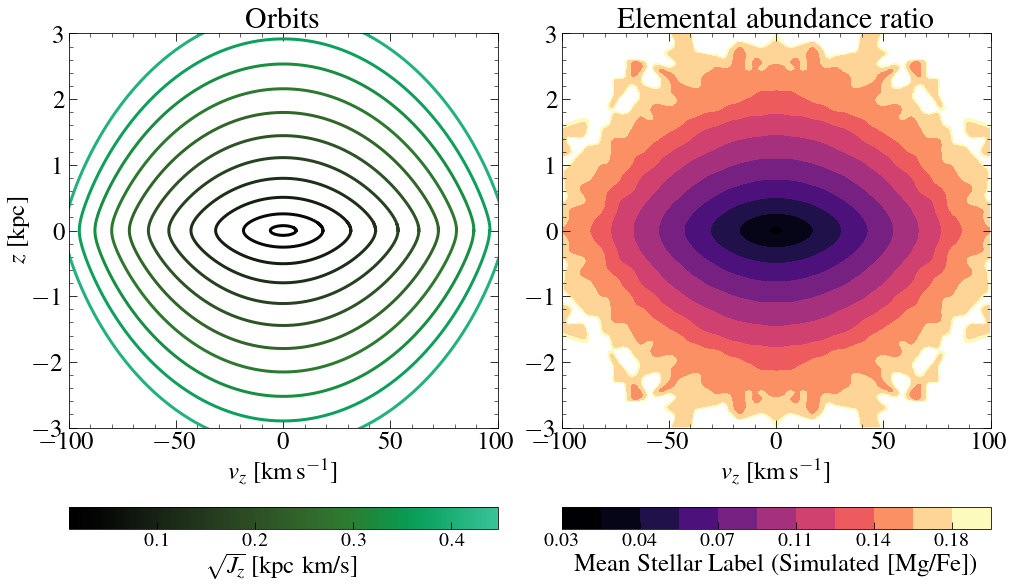

In [41]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(14,8),
    constrained_layout=True,
    facecolor='white'
)

# cmap_Jz = cmr.get_sub_cmap(cmr.ember, 0.2, 1.)
cmap_Jz = cmr.get_sub_cmap(cmr.emerald, 0.0, 0.8)
norm_Jz = mpl.colors.Normalize(
    vmin=np.sqrt(Jzs.value).min(),
    vmax=np.sqrt(Jzs.value).max(),
)


# Orbits:
orbit_axes = [axes[0]]
for ax in orbit_axes:
    for (z, vz), Jz in zip(zvzs[:-1], Jzs[:-1]):
        ax.plot(vz, z, marker="", ls="-", lw=3, color=cmap_Jz(norm_Jz(np.sqrt(Jz.value))))
        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=8)
        ax.tick_params(which='minor', length=4, direction='in',top=True,right=True)
        ax.minorticks_on()
        ax.set_ylim(-3,3)
        ax.set_xlim(-100,100)
sm = plt.cm.ScalarMappable(cmap=cmap_Jz, norm=norm_Jz)
sm.set_array([])
cb = fig.colorbar(sm, ax=axes[0], orientation="horizontal", location="bottom")
cb.set_label(r"$\sqrt{J_z}$ [kpc km/s]", fontsize=25)
cb.ax.tick_params(labelsize=20,direction='in',length=7)
cb.ax.xaxis.set_ticks_position('bottom')
cb.ax.xaxis.set_label_position('bottom')
# cs = axes[1].pcolormesh(xc, yc, H_abun.T, cmap=cmap_abun, norm=norm_abun)
# cb = fig.colorbar(cs, ax=axes[0, 2], orientation="horizontal", location="top")
# cb.set_label("Mean Stellar Label\n(Simulated [Mg/Fe])", fontsize=title_size)


sm2 = axes[1].contourf(
    xc, yc, H_abun_sm.T, levels=abun_levels, cmap='magma', zorder=-10
)
axes[1].tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=8)
axes[1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1].minorticks_on()
axes[1].set_ylim(-3,3)
axes[1].set_xlim(-100,100)
cb = fig.colorbar(sm2, ax=axes[1], orientation="horizontal", location="bottom",format="%.2f")
cb.set_label(r'Mean Stellar Label (Simulated [Mg/Fe])', fontsize=25)
cb.ax.tick_params(labelsize=20,direction='in',length=7)
cb.ax.xaxis.set_ticks_position('bottom')
cb.ax.xaxis.set_label_position('bottom')

for ax in axes:
    ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]",fontsize=25)
axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]",fontsize=25)

axes[0].set_title("Orbits",fontsize=30)
axes[1].set_title("Elemental abundance ratio",fontsize=30)


# plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/models.pdf',dpi=600,fmt='pdf', bbox_inches = 'tight', rasterized=True)


In [42]:
import cmasher as cmr
from scipy import stats

In [43]:
# LOAD THE DATA
# this is the latest APOGEE catalogue that APW sent me with orbital properties determined using StarHorse distances

path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
tb = fits.open(path)
data_mw = tb[1].data 

# load in the mask for the lowalpha disc
lowa = np.load('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/sav/lowa_mask.npy',allow_pickle=True)


In [44]:
# find the Suns Rg
x_sun, y_sun, z_sun = np.array([-8.275, 0, 0.0208])
vx_sun, vy_sun, vz_sun = np.array([8.4, 251.8, 8.4])
Lz_sun = x_sun*vy_sun
Rg_sun = np.abs(Lz_sun)/229.

import astropy.units as u
x = data_mw['xyz'][:,0]
y = data_mw['xyz'][:,1]
z = data_mw['xyz'][:,2]
vx = data_mw['vxyz'][:,0]
vy = data_mw['vxyz'][:,1]
vz = data_mw['vxyz'][:,2]
vz = (vz*u.km/u.s)
vz = vz.to(u.kpc/u.Gyr)
x = x*u.kpc
y = y*u.kpc
z = z*u.kpc

# Eilers rotation curve
Rgal = np.sqrt(data_mw['xyz'][:,0]**2+data_mw['xyz'][:,1]**2)
vcirc = 229.-1.7*(Rgal-8.275)
Rg = -(data_mw['L'][:,2]/vcirc)
deltaR = Rgal-Rg
phi = np.arctan(data_mw['xyz'][:,1]/data_mw['xyz'][:,0])

#transform to cylindrical velocities
vr = +data_mw['vxyz'][:,0]*np.cos(phi)+data_mw['vxyz'][:,1]*np.sin(phi)
vt = -data_mw['vxyz'][:,0]*np.sin(phi)+data_mw['vxyz'][:,1]*np.cos(phi)

# so that we can apply OTI, we need to have some good approximation to circular orbits that are decomposable in R and z
# omask = (np.fabs(z)<2*u.kpc)&(np.fabs(vz)<80*u.kpc/u.Gyr)&(np.fabs(deltaR)<3)
omask = (np.abs(z)<3*u.kpc)&(np.abs(vz)<100*u.kpc/u.Gyr)&(np.abs(deltaR)<1)&(np.abs(vr)<50)
# maybe try 40
# &(data['ecc']<0.2)
lowa_omask = lowa&omask
# lowa_omask2 = lowa&omask2

print('There are '+str(len(data_mw[lowa]))+' stars in the parent sample')
print('There are '+str(len(data_mw[lowa_omask]))+' stars in the sample we model')

There are 172656 stars in the parent sample
There are 95881 stars in the sample we model


In [45]:
delta = 1 # chose 1 here as any smaller bin there isnt enough data
R_sun = 8.275
rgbin = (Rgal>(R_sun-delta))&(Rgal<(R_sun+delta))&omask&lowa &(data_mw['MG_FE']>-10)&(data_mw['MG_FE_ERR']>-10)&(np.abs(data_mw['MG_FE'])<0.2)
print(len(data_mw[rgbin]))


37949


Text(0.5, 1.0, 'Model')

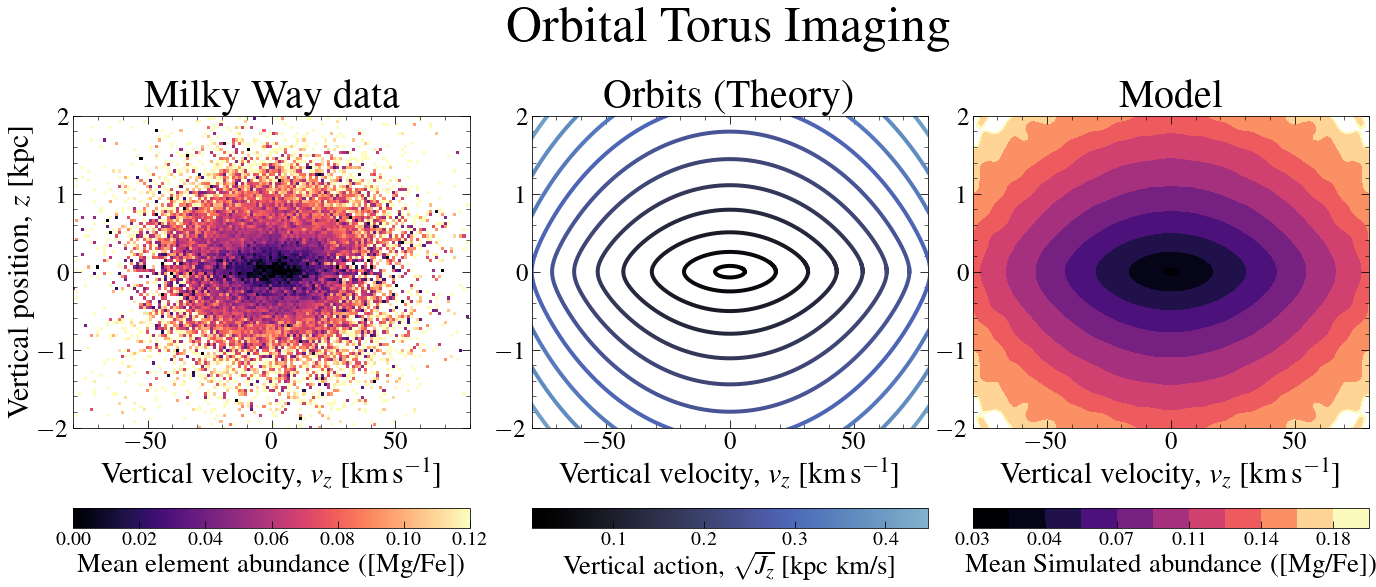

In [47]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(19,7),
    constrained_layout=True,
    facecolor='white',
    rasterized=True
    )

fig.suptitle('Orbital Torus Imaging',fontsize=50,x=0.53,y=1.14)

# cmap_Jz = cmr.get_sub_cmap(cmr.ember, 0.2, 1.)
cmap_Jz = cmr.get_sub_cmap(cmr.sapphire, 0.0, 0.8)
norm_Jz = mpl.colors.Normalize(
    vmin=np.sqrt(Jzs.value).min(),
    vmax=np.sqrt(Jzs.value).max(),
)

#data
abun = data_mw['MG_FE']
binx = np.linspace(np.min(data_mw['vxyz'][:,2][rgbin]),np.max(data_mw['vxyz'][:,2][rgbin]),151)
biny = np.linspace(np.min(data_mw['xyz'][:,2][rgbin]),np.max(data_mw['xyz'][:,2][rgbin]),151)    
hist = stats.binned_statistic_2d(data_mw['vxyz'][:,2][rgbin],data_mw['xyz'][:,2][rgbin], abun[rgbin], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
sm0 = axes[0].pcolormesh(plot_x, plot_y, hist[0].T, cmap='magma',vmin=0.,vmax=0.12)
axes[0].tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=8)
axes[0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0].minorticks_on()
axes[0].set_ylim(-2,2)
axes[0].set_xlim(-80,80)
cb = fig.colorbar(sm0, ax=axes[0], orientation="horizontal", location="bottom",format="%.2f")
cb.set_label(r'Mean element abundance ([Mg/Fe])', fontsize=27)
cb.ax.tick_params(labelsize=20,direction='in',length=7)
cb.ax.xaxis.set_ticks_position('bottom')
cb.ax.xaxis.set_label_position('bottom')

# Orbits:
orbit_axes = [axes[1]]
for ax in orbit_axes:
    for (z, vz), Jz in zip(zvzs[:-1], Jzs[:-1]):
        ax.plot(vz, z, marker="", ls="-", lw=4, color=cmap_Jz(norm_Jz(np.sqrt(Jz.value))))
        ax.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=8)
        ax.tick_params(which='minor', length=4, direction='in',top=True,right=True)
        ax.minorticks_on()
        ax.set_ylim(-2,2)
        ax.set_xlim(-80,80)
sm = plt.cm.ScalarMappable(cmap=cmap_Jz, norm=norm_Jz)
sm.set_array([])
cb = fig.colorbar(sm, ax=axes[1], orientation="horizontal", location="bottom")
cb.set_label(r"Vertical action, $\sqrt{J_z}$ [kpc km/s]", fontsize=27)
cb.ax.tick_params(labelsize=20,direction='in',length=7)
cb.ax.xaxis.set_ticks_position('bottom')
cb.ax.xaxis.set_label_position('bottom')
# cs = axes[1].pcolormesh(xc, yc, H_abun.T, cmap=cmap_abun, norm=norm_abun)
# cb = fig.colorbar(cs, ax=axes[0, 2], orientation="horizontal", location="top")
# cb.set_label("Mean Stellar Label\n(Simulated [Mg/Fe])", fontsize=title_size)


sm2 = axes[2].contourf(
    xc, yc, H_abun_sm.T, levels=abun_levels, cmap='magma', zorder=-10,
)
axes[2].tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=8)
axes[2].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[2].minorticks_on()
axes[2].set_ylim(-2,2)
axes[2].set_xlim(-80,80)
cb = fig.colorbar(sm2, ax=axes[2], orientation="horizontal", location="bottom",format="%.2f")
cb.set_label(r'Mean Simulated abundance ([Mg/Fe])', fontsize=27)
cb.ax.tick_params(labelsize=20,direction='in',length=7)
cb.ax.xaxis.set_ticks_position('bottom')
cb.ax.xaxis.set_label_position('bottom')

for ax in axes:
    ax.set_xlabel(f"Vertical velocity, $v_z$ [{u.km/u.s:latex_inline}]",fontsize=30)

axes[0].set_ylabel(f"Vertical position, $z$ [{u.kpc:latex_inline}]",fontsize=30)
axes[0].set_title("Milky Way data",fontsize=40)
axes[1].set_title("Orbits (Theory)",fontsize=40)
axes[2].set_title("Model",fontsize=40)


# plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/models-app.pdf',dpi=400, bbox_inches = 'tight')
